In [1]:
!pip install kaggle

In [2]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [3]:
!kaggle competitions download -c dogs-vs-cats

 97% 788M/812M [00:07<00:00, 306MB/s]
100% 812M/812M [00:07<00:00, 115MB/s]


In [4]:
!ls

dogs-vs-cats.zip  kaggle.json  sample_data


In [5]:
from zipfile import ZipFile

dataset = "/content/dogs-vs-cats.zip"

with ZipFile(dataset,'r') as zip:
  zip.extractall()
  print("The dataset is extracted")

The dataset is extracted


In [6]:
from zipfile import ZipFile

dataset = '/content/train.zip'

with ZipFile(dataset, 'r') as zip:
  zip.extractall()
  print('The dataset is extracted')

The dataset is extracted


In [7]:
import os
path, dirs, files = next(os.walk('/content/train'))
file_count = len(files)
print("Number of images: ",file_count)


Number of images:  25000


In [8]:
file_name = os.listdir('/content/train')
#Print file_name
for i in range(11):
  print(file_name[i])

cat.2870.jpg
cat.9940.jpg
dog.8601.jpg
dog.2332.jpg
cat.1194.jpg
cat.6042.jpg
dog.3286.jpg
dog.11499.jpg
cat.9210.jpg
cat.3442.jpg
cat.11993.jpg


In [9]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.model_selection import train_test_split
from google.colab.patches import cv2_imshow

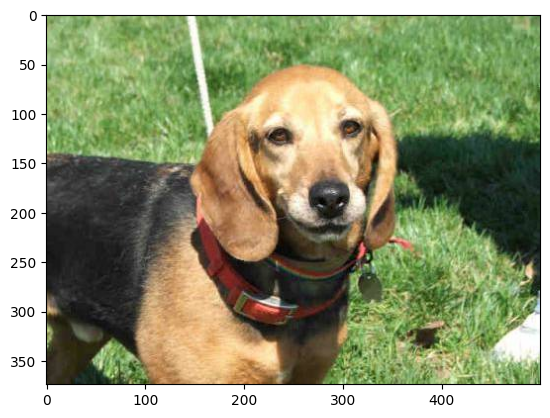

In [10]:
img = mpimg.imread('/content/train/dog.1206.jpg')
plt.imshow(img)


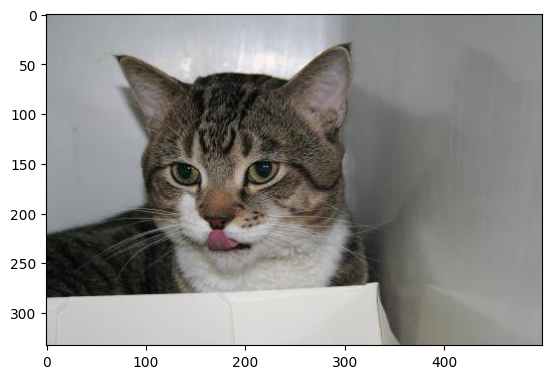

In [11]:
img = mpimg.imread('/content/train/cat.1972.jpg')
plt.imshow(img)


In [12]:
file_name = os.listdir('/content/train')

for i in range(3,9):
  name = file_name[i]
  # print(name)
  print(name[0:3])

dog
cat
cat
dog
dog
cat


In [13]:
file_name = os.listdir('/content/train')

dog_count = 0
cat_count = 0
for img_file in file_name:
  name = img_file[0:3]
  if name == 'dog':
    dog_count += 1
  else:
    cat_count += 1

print("Number of dog images: ",dog_count)
print("Number of cat images: ", cat_count)

Number of dog images:  12500
Number of cat images:  12500


In [14]:
os.mkdir('/content/image resized')

In [15]:
original_folder = '/content/train/'
resized_folder = '/content/image resized/'

for i in range(2000):
  filename = os.listdir(original_folder)[i]
  img_path = original_folder + filename

  img = Image.open(img_path)
  img = img.resize((224,224))
  img = img.convert("RGB")

  newImgPath = resized_folder + filename
  img.save(newImgPath)

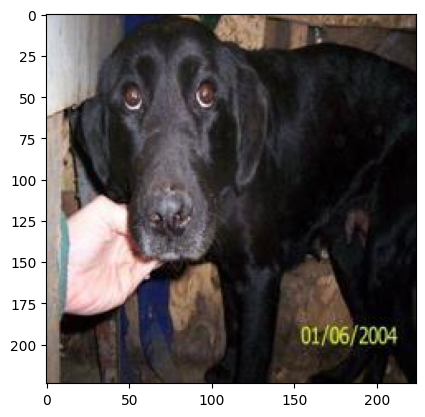

In [17]:
#display resized dog images

img = mpimg.imread('/content/image resized/dog.8601.jpg')
plt.imshow(img)
plt.show()

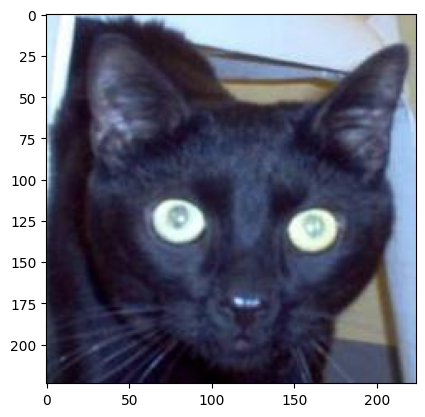

In [19]:
img = mpimg.imread('/content/image resized/cat.9210.jpg')
plt.imshow(img)


###Creating labels for reseized images of dogs and cats

Cat->0

Dog->1

In [20]:

filenames = os.listdir('/content/image resized/')

labels = []

for i in range(2000):
  file_name = filenames[i]
  label = file_name[0:3]

  if label=='dog':
    labels.append(1)
  else:
    labels.append(0)

In [21]:
print(filenames[0:5])
print(len(filenames))

['cat.2870.jpg', 'cat.9940.jpg', 'dog.8601.jpg', 'dog.2332.jpg', 'cat.1194.jpg']
2000


In [22]:
print(labels[0:5])

print(len(labels))

[0, 0, 1, 1, 0]
2000


In [23]:
# counting the images of dogs and cats out of 2000 images

values, counts = np.unique(labels, return_counts=True)
print(values)
print(counts)

[0 1]
[1025  975]


In [24]:
import cv2
import glob

In [25]:
image_directory = '/content/image resized/'
image_extension = ['png','jpg']

files=[]
[files.extend(glob.glob(image_directory + '*.'+e)) for e in image_extension]

dog_cat_images = np.asarray([cv2.imread(file) for file in files])

In [26]:
type(dog_cat_images)

numpy.ndarray

In [27]:
print(dog_cat_images.shape)

(2000, 224, 224, 3)


In [28]:
X = dog_cat_images
Y = np.asarray(labels)

In [29]:
X_train, X_test, Y_train , Y_test = train_test_split(X,Y,test_size = 0.2, random_state=2)

In [30]:
print(X.shape, X_train.shape, X_test.shape)


(2000, 224, 224, 3) (1600, 224, 224, 3) (400, 224, 224, 3)


1600 -> training images

400 -> test images

In [31]:
X_train_scaled = X_train/255
X_test_scaled = X_test/255

In [32]:
import tensorflow as tf
import tensorflow_hub as hub

In [33]:
mobilenet_model = 'https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4'

pretrained_model = hub.KerasLayer(mobilenet_model, input_shape=(224,224,3),trainable=False)

In [35]:
num_of_classes = 2

In [36]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model

# Load the MobileNetV2 model with pre-trained weights (excluding the top classification layer)
base_model = MobileNetV2(input_shape=(224, 224, 3),
                         include_top=False,
                         weights='imagenet')

# Freeze the base model layers
base_model.trainable = False

# Add custom layers on top of the base model
x = base_model.output
x = GlobalAveragePooling2D()(x) # Add a global average pooling layer
output_layer = Dense(num_of_classes, activation='softmax')(x) # Add a dense output layer for classification

# Create the new model
model = Model(inputs=base_model.input, outputs=output_layer)

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer_1[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,260,546 (8.62 MB)

 Trainable params: 2,562 (10.01 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [37]:
model.compile(
    optimizer = 'adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics = ['acc']
)

In [38]:
model.fit(X_train_scaled,Y_train,epochs=5)

Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/nn.py:708: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


50/50 ━━━━━━━━━━━━━━━━━━━━ 13s 41ms/step - acc: 0.7579 - loss: 0.4901
Epoch 2/5
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - acc: 0.9672 - loss: 0.0869
Epoch 3/5
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - acc: 0.9759 - loss: 0.0658
Epoch 4/5
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - acc: 0.9769 - loss: 0.0618
Epoch 5/5
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - acc: 0.9838 - loss: 0.0554


In [39]:
score, acc = model.evaluate(X_test_scaled,Y_test)
print('Test Loss =',score)
print("Test Accuracy =",acc)

13/13 ━━━━━━━━━━━━━━━━━━━━ 7s 280ms/step - acc: 0.9886 - loss: 0.0434
Test Loss = 0.04210252687335014
Test Accuracy = 0.987500011920929


Path of the image to be predicted: /content/DOG.jpeg


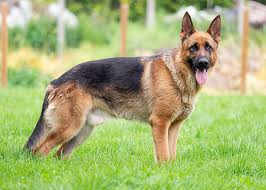

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
[[0.00890252 0.99109745]]
1
The image represents a Dog


In [40]:
input_image_path = input('Path of the image to be predicted: ')

input_image = cv2.imread(input_image_path)

cv2_imshow(input_image)
input_image_resize = cv2.resize(input_image,(224,224))

input_image_scaled = input_image_resize/255

image_reshaped = np.reshape(input_image_scaled,[1,224,224,3])

input_prediction = model.predict(image_reshaped)

print(input_prediction)

input_pred_label = np.argmax(input_prediction)  #Checks max probability

print(input_pred_label)

if input_pred_label == 0:
  print('The image represents a Cat')
else:
  print('The image represents a Dog')

Path of the image to be predicted: /content/CAT.jpeg


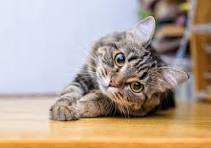

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
[[0.99585706 0.0041429 ]]
0
The image represents a Cat


In [41]:
input_image_path = input('Path of the image to be predicted: ')

input_image = cv2.imread(input_image_path)

cv2_imshow(input_image)
input_image_resize = cv2.resize(input_image,(224,224))

input_image_scaled = input_image_resize/255

image_reshaped = np.reshape(input_image_scaled,[1,224,224,3])

input_prediction = model.predict(image_reshaped)

print(input_prediction)

input_pred_label = np.argmax(input_prediction)  #Checks max probability

print(input_pred_label)

if input_pred_label == 0:
  print('The image represents a Cat')
else:
  print('The image represents a Dog')